In [23]:
from cpc_pipeline import *

from llm import LLM
gpt35t = LLM("gpt-3.5-turbo")
gpt4 = LLM("gpt-4")

In [24]:
import nltk
import random

max_shift = 5

filtered_corpus = [s for s in nltk.corpus.abc.words() if s.lower() == s]
def make_caesar_cipher(word_length, shift):
    word = random.choice([s for s in filtered_corpus if len(s) == word_length])
    return ''.join([chr((ord(c) + shift - 97) % 26 + 97) for c in word]), word

problem_df = cpc_problems(make_caesar_cipher, {'word_length': [3,4,5], 'shift':range(1, max_shift+1)}, n=1, unwrap_colnames=['problem', 'original'])

Reading cpc_pipeline/make_caesar_cipher3286947891.csv...


In [25]:
prompt = f"This ciphertext is either an anagram or a Caesar cipher. First, assume it's an anagram, and try to unscramble it. If that doesn't work, continue by assuming it's a Caesar cipher and try to decrypt it. Show your work using at least {max_shift} different shifts. "+"Ciphertext: {ciphertext}"
false_start = "Ok, I'll start by treating the ciphertext as an anagram and trying to unscramble it."

def solve_caesar_gpt35t(problem):
    return gpt35t.chat_completion_false_start(prompt.format(ciphertext=problem), false_start=false_start)

def solve_caesar_gpt4(problem):
    return gpt4.chat_completion_false_start(prompt.format(ciphertext=problem), false_start=false_start)

context_df_35t = cpc_contexts(problem_df, solve_caesar_gpt35t)
context_df_4 = cpc_contexts(problem_df, solve_caesar_gpt4)

Reading cpc_pipeline/solve_caesar_gpt35t4090895247.csv...
Reading cpc_pipeline/solve_caesar_gpt42184766945.csv...


In [26]:
context_df_35t['correct'] = context_df_35t.apply(lambda x: 1 if x['original'] in x['context'] else 0, axis=1)
print(np.mean(context_df_35t['correct']))
context_df_4['correct'] = context_df_4.apply(lambda x: 1 if x['original'] in x['context'] else 0, axis=1)
print(np.mean(context_df_4['correct']))

0.4
0.6


In [27]:
from new_switch_utils import make_non_decreasing

anagram_switching_prompt = "This is a reasoning transcript of an agent trying to decipher some ciphertext. The agent will start treating the ciphertext as an anagram and attempting to unscramble it. The agent may then give up and treat the ciphertext as a Caesar cipher instead. First you will be shown the full transcript, then just a prefix of the transcript. By the end of the prefix transcript, has the agent switched from treating the ciphertext as an anagram to treating it as a Caesar cipher yet?"
def judge_anagram_switching(context, prefix):
        return 1 if gpt4.yesno_completion(anagram_switching_prompt+'\n\nFULL TRANSCRIPT:\n'+context+'\n\nPREFIX TRANSCRIPT:\n'+prefix+"\n\nANSWER:\n") == 'Yes' else 0

def split_and_judge_gpt4(context, chunk_size):
    prefixes = [context[:pref_end] for pref_end in range(chunk_size, len(context)+chunk_size, chunk_size)]
    measured_switching = [judge_anagram_switching(context, prefix) for prefix in prefixes]
    processed_switching = random.choice(make_non_decreasing(measured_switching))
    return prefixes, processed_switching

switching_df_35t = split_and_judge_switching(context_df_35t, split_and_judge_gpt4, 50)
switching_df_4 = split_and_judge_switching(context_df_4, split_and_judge_gpt4, 50)

Reading cpc_pipeline/split_and_judge_gpt41468298456.csv...
Reading cpc_pipeline/split_and_judge_gpt43655789466.csv...


In [28]:
anagram_cpc_prompt = """At this point, we're going to stop and consider whether this approach is working or not 
              and leads to a correct solution to the problem being worked on. 
              Otherwise, we should step back and try a different approach."""

from solver import perform_one_token_cpc, perform_cot_cpc
def gpt35t_1t(context):
    return perform_one_token_cpc(gpt35t, context, prompt=anagram_cpc_prompt)
def gpt35t_cot(context):
    return perform_cot_cpc(gpt35t, context, prompt=anagram_cpc_prompt)
def gpt4_1t(context):
    return perform_one_token_cpc(gpt4, context, prompt=anagram_cpc_prompt)
def gpt4_cot(context):
    return perform_cot_cpc(gpt4, context, prompt=anagram_cpc_prompt)

cpc_df_35t = judge_cpc(switching_df_35t, [gpt35t_1t, gpt35t_cot], radius_right=7)
cpc_df_4 = judge_cpc(switching_df_4, [gpt4_1t, gpt4_cot], radius_right=7)

Creating cpc_pipeline/cpc_1533880778.csv...
Creating cpc_pipeline/cpc_3819129300.csv...


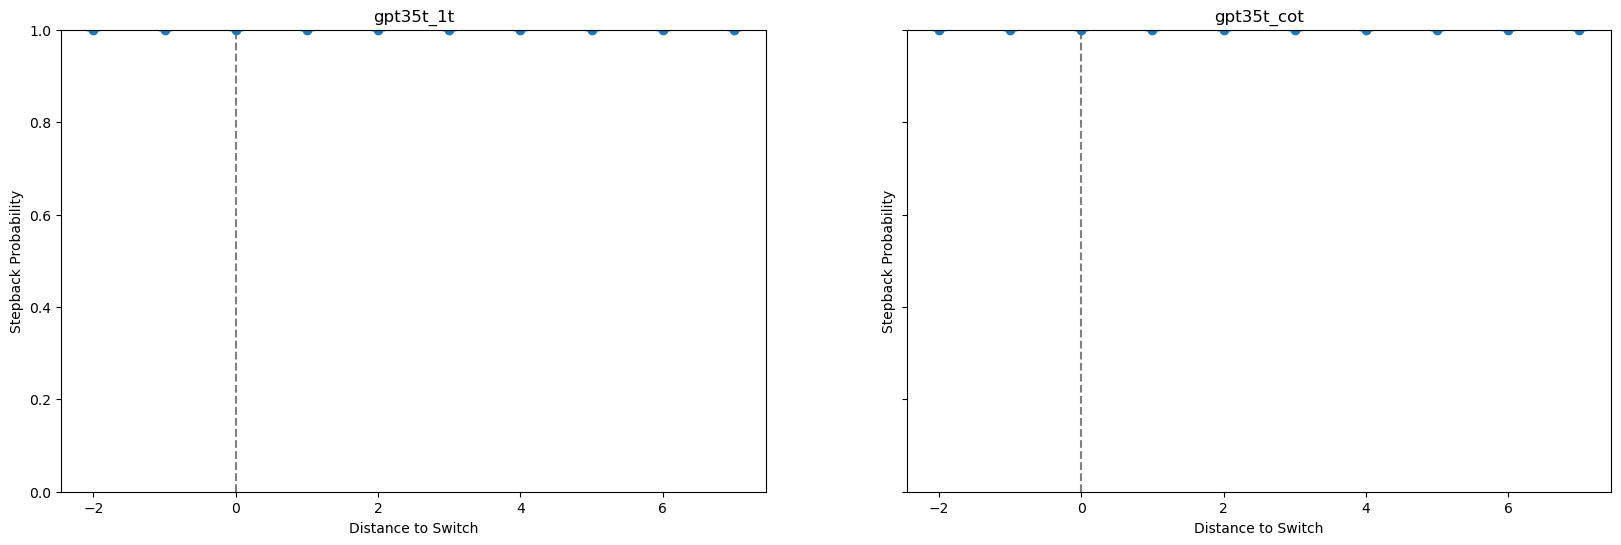

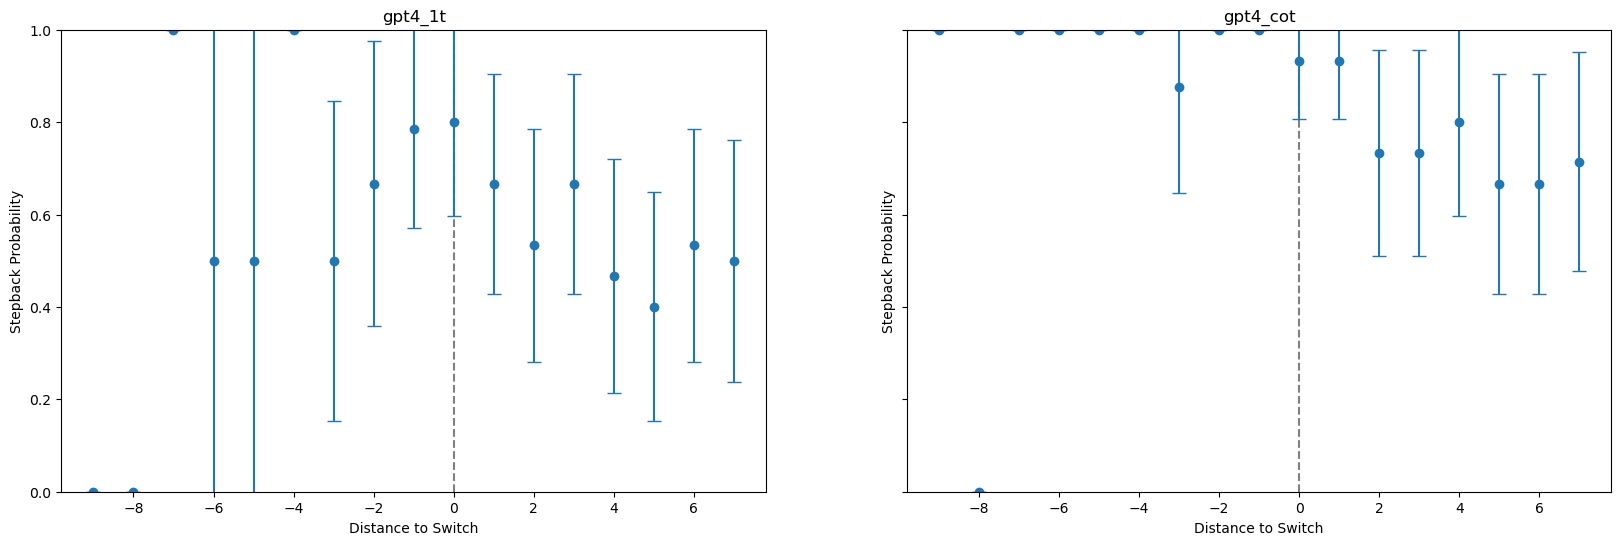

In [37]:
do_analysis(cpc_df_35t, [gpt35t_1t, gpt35t_cot])
do_analysis(cpc_df_4, [gpt4_1t, gpt4_cot])

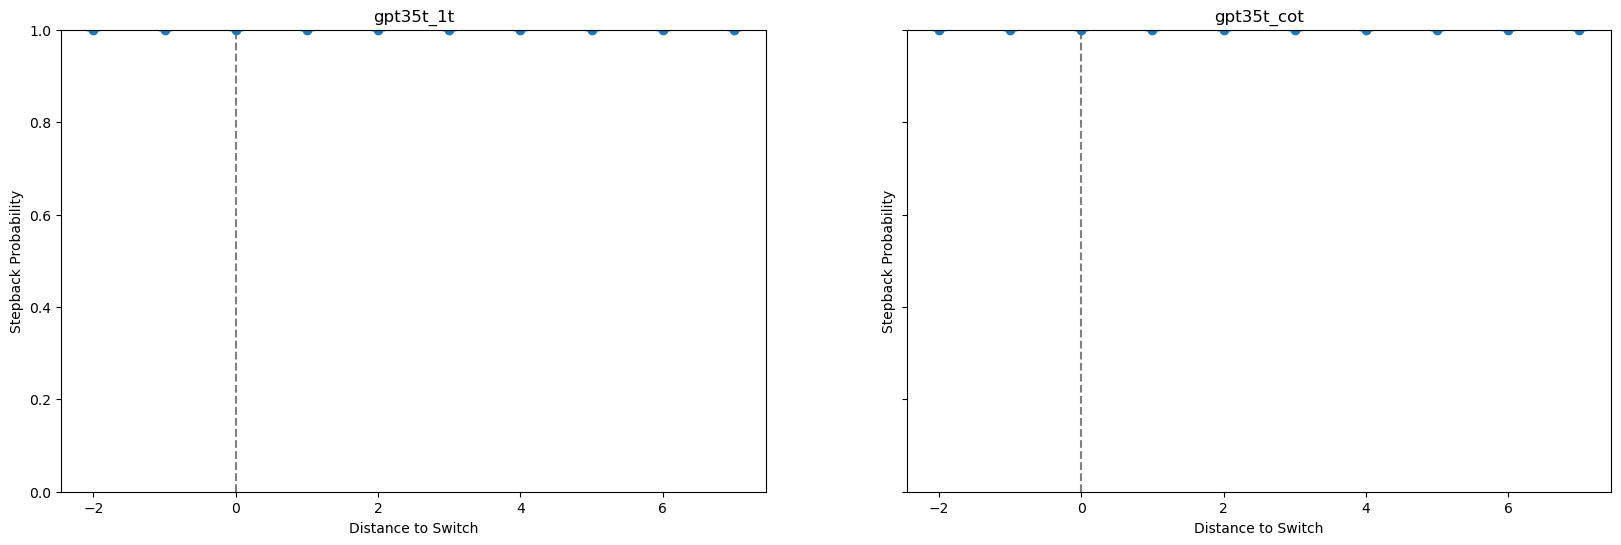

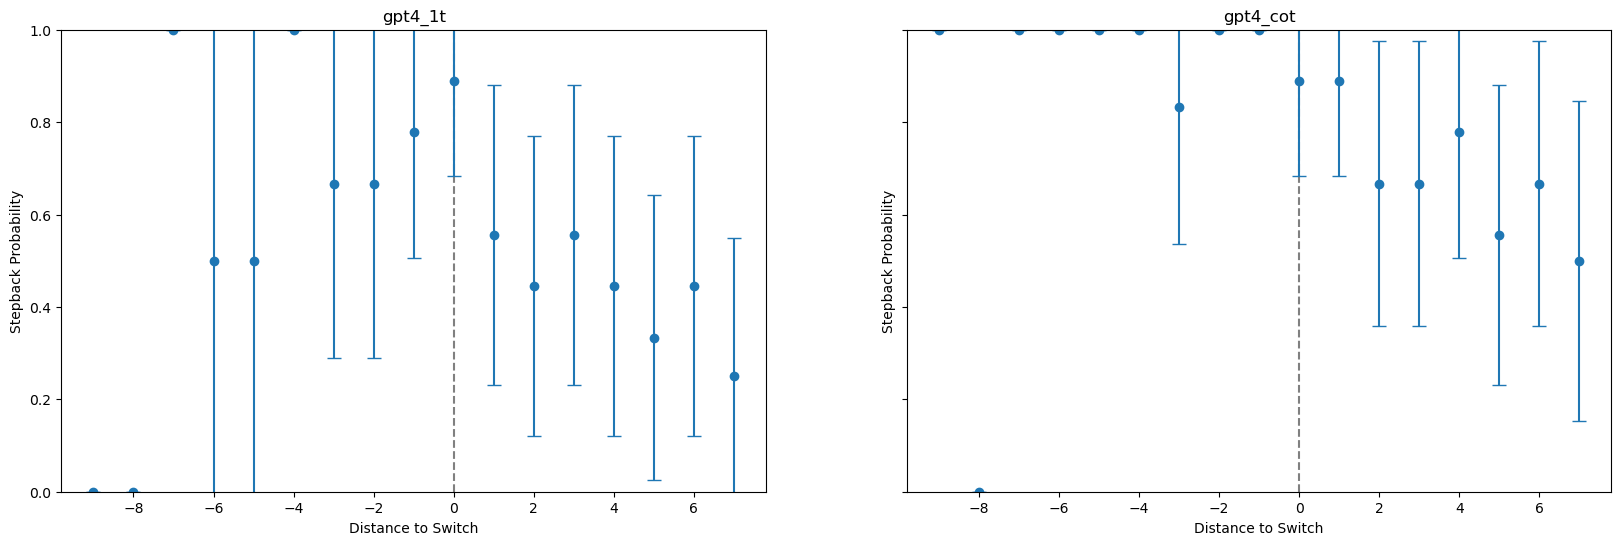

In [38]:
do_analysis(cpc_df_35t.loc[cpc_df_35t['correct'] == 1], [gpt35t_1t, gpt35t_cot])
do_analysis(cpc_df_4.loc[cpc_df_4['correct'] == 1], [gpt4_1t, gpt4_cot])

In [47]:
cpc_df_4['gpt4_cot_1'][1]

"The current approach consists of forming anagrams with the input string 'bsf'. However, in the context of cryptography, without any additional information, anagrams usually do not play a significant role in decryption. The lack of information such as a key or algorithm makes it more complicated to decipher a possible meaning of the word 'bsf'. The anagrams formed here are also not recognized English words.\n\nTherefore, I recommend a different approach. Depending on the algorithm applied, different cryptographic methods can be used. For example, if it is a simple caesar cipher, we need to shift the letters in the alphabet by a certain amount. Other methods include substitution ciphers, where we need a comparison table to help decode the message. A different context or more background information about the cipher would be helpful to decrypt the ciphertext."

In [44]:
cpc_df_35t.loc[cpc_df_35t['dist_to_switch']==3]['gpt35t_cot_1'][4]

'Analyzing the current approach of attempting to decrypt "bsf" using a Caesar cipher:\n\n- We tried decrypting the cipher text "bsf" with different shifts but did not find any meaningful words.\n- It is possible that "bsf" may not be encrypted using a simple Caesar cipher with a single shift.\n- The result "are" from decrypting with a shift of 1 does not seem to provide any meaningful solution to the problem at hand.\n\nConsidering the lack of success thus far in decrypting "bsf" using a Caesar cipher approach, it may be a good idea to recommend a different approach.'

35t seems to be concluding "yes switch" even after the switch because it sees that the Caesar decodes so far haven't worked. 

4 concludes "yes switch" right off the bat in cot because it can try an anagram and see that it doesn't work.